In [1]:
# importing libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import layers, optimizers
from tensorflow.keras import activations
from sklearn.metrics import mean_squared_error
from plot_keras_history import plot_history
import matplotlib.pyplot as plt
import matplotlib as mpl

# mpl.rcParams['figure.figsize'] = (12,10)
mpl.rcParams['axes.grid'] = True

In [2]:
# load dataset
df = pd.read_csv('./data/taxi.csv')
df['DateTime'] = pd.to_datetime(df['datetime'])
data_hourly = df.resample('1H', on='DateTime').sum()
data_hourly

,num_orders
DateTime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


In [3]:
#converting series to supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [4]:
# storing row values as array
values = data_hourly.values
data_hourly.dtypes

num_orders    int64
dtype: object

In [5]:
# Scaling full data using the MinMaxScaler, since all the column values are float
# Variables that are measured at different scales do not contribute equally to the model fitting & model learned function and might end up creating a bias. Thus, to deal with this  # potential problem, feature-wise normalization such as MinMax Scaling is usually used prior to model fitting
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(values)

# changing data to supervised data as described above
reframed_data = series_to_supervised(data_scaled, 24,1)
# checking head of supervised data
reframed_data.head()

,var1(t-24),var1(t-23),var1(t-22),var1(t-21),var1(t-20),var1(t-19),var1(t-18),var1(t-17),var1(t-16),var1(t-15),...,var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
24,0.268398,0.183983,0.153680,0.142857,0.093074,0.012987,0.025974,0.032468,0.073593,0.149351,...,0.142857,0.093074,0.095238,0.158009,0.097403,0.132035,0.142857,0.244589,0.125541,0.194805
25,0.183983,0.153680,0.142857,0.093074,0.012987,0.025974,0.032468,0.073593,0.149351,0.138528,...,0.093074,0.095238,0.158009,0.097403,0.132035,0.142857,0.244589,0.125541,0.194805,0.259740
26,0.153680,0.142857,0.093074,0.012987,0.025974,0.032468,0.073593,0.149351,0.138528,0.207792,...,0.095238,0.158009,0.097403,0.132035,0.142857,0.244589,0.125541,0.194805,0.259740,0.162338
27,0.142857,0.093074,0.012987,0.025974,0.032468,0.073593,0.149351,0.138528,0.207792,0.064935,...,0.158009,0.097403,0.132035,0.142857,0.244589,0.125541,0.194805,0.259740,0.162338,0.138528
28,0.093074,0.012987,0.025974,0.032468,0.073593,0.149351,0.138528,0.207792,0.064935,0.069264,...,0.097403,0.132035,0.142857,0.244589,0.125541,0.194805,0.259740,0.162338,0.138528,0.043290


In [6]:
reframed_data.shape

(4392, 25)

In [7]:
# storing dataframe as array 
values = reframed_data.values

In [8]:
# training_split=287
train = values[:3952, :]
test = values[-440:, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features] for inputs to LSTM models
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(3952, 1, 24) (3952,) (440, 1, 24) (440,)


In [10]:
import tensorflow as tf
tf.keras.backend.clear_session()

In [11]:
# LSTM network design: We use a small 2-layered LSTM model with 1 dropout layer to start with
model2 = Sequential()
# LSTM Block
model2.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True)) 
model2.add(LSTM(20, return_sequences = False)) 
# Dense and Output Layer
model2.add(Dense(16))
model2.add(Dropout(0.15))
model2.add(Dense(4))
model2.add(Dense(1))

opt = optimizers.Adam(learning_rate=0.001)
model2.compile(loss='MAE', optimizer=opt, metrics=["MSE"])

# viewing model summary
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 50)             15000     
                                                                 
 lstm_1 (LSTM)               (None, 20)                5680      
                                                                 
 dense (Dense)               (None, 16)                336       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 68        
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
Total params: 21,089
Trainable params: 21,089
Non-traina

In [12]:
# fit network
history2 = model2.fit(train_X, train_y, epochs=100, batch_size=72, validation_split=0.2, verbose=2, shuffle=True)

Epoch 1/100
44/44 - 11s - loss: 0.0803 - MSE: 0.0105 - val_loss: 0.0870 - val_MSE: 0.0129 - 11s/epoch - 250ms/step
Epoch 2/100
44/44 - 0s - loss: 0.0557 - MSE: 0.0052 - val_loss: 0.0782 - val_MSE: 0.0108 - 483ms/epoch - 11ms/step
Epoch 3/100
44/44 - 0s - loss: 0.0530 - MSE: 0.0047 - val_loss: 0.0671 - val_MSE: 0.0081 - 478ms/epoch - 11ms/step
Epoch 4/100
44/44 - 0s - loss: 0.0480 - MSE: 0.0038 - val_loss: 0.0592 - val_MSE: 0.0063 - 472ms/epoch - 11ms/step
Epoch 5/100
44/44 - 0s - loss: 0.0446 - MSE: 0.0033 - val_loss: 0.0580 - val_MSE: 0.0061 - 472ms/epoch - 11ms/step
Epoch 6/100
44/44 - 0s - loss: 0.0438 - MSE: 0.0032 - val_loss: 0.0575 - val_MSE: 0.0059 - 477ms/epoch - 11ms/step
Epoch 7/100
44/44 - 0s - loss: 0.0421 - MSE: 0.0031 - val_loss: 0.0556 - val_MSE: 0.0054 - 480ms/epoch - 11ms/step
Epoch 8/100
44/44 - 1s - loss: 0.0419 - MSE: 0.0030 - val_loss: 0.0556 - val_MSE: 0.0053 - 516ms/epoch - 12ms/step
Epoch 9/100
44/44 - 0s - loss: 0.0408 - MSE: 0.0029 - val_loss: 0.0547 - val_MSE

Epoch 72/100
44/44 - 0s - loss: 0.0370 - MSE: 0.0024 - val_loss: 0.0526 - val_MSE: 0.0049 - 485ms/epoch - 11ms/step
Epoch 73/100
44/44 - 0s - loss: 0.0371 - MSE: 0.0024 - val_loss: 0.0530 - val_MSE: 0.0052 - 477ms/epoch - 11ms/step
Epoch 74/100
44/44 - 0s - loss: 0.0369 - MSE: 0.0024 - val_loss: 0.0535 - val_MSE: 0.0052 - 479ms/epoch - 11ms/step
Epoch 75/100
44/44 - 1s - loss: 0.0369 - MSE: 0.0024 - val_loss: 0.0544 - val_MSE: 0.0054 - 515ms/epoch - 12ms/step
Epoch 76/100
44/44 - 0s - loss: 0.0368 - MSE: 0.0024 - val_loss: 0.0534 - val_MSE: 0.0052 - 455ms/epoch - 10ms/step
Epoch 77/100
44/44 - 0s - loss: 0.0371 - MSE: 0.0024 - val_loss: 0.0540 - val_MSE: 0.0054 - 497ms/epoch - 11ms/step
Epoch 78/100
44/44 - 0s - loss: 0.0372 - MSE: 0.0024 - val_loss: 0.0526 - val_MSE: 0.0050 - 472ms/epoch - 11ms/step
Epoch 79/100
44/44 - 0s - loss: 0.0373 - MSE: 0.0024 - val_loss: 0.0532 - val_MSE: 0.0051 - 491ms/epoch - 11ms/step
Epoch 80/100
44/44 - 0s - loss: 0.0370 - MSE: 0.0024 - val_loss: 0.0541 

In [34]:
yhat = model2.predict(test_X)
test_X_reshape = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecasted values
inv_yhat = np.concatenate((yhat, test_X_reshape[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

In [36]:
# invert scaling for actual values
test_y_reshape = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y_reshape, test_X_reshape[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

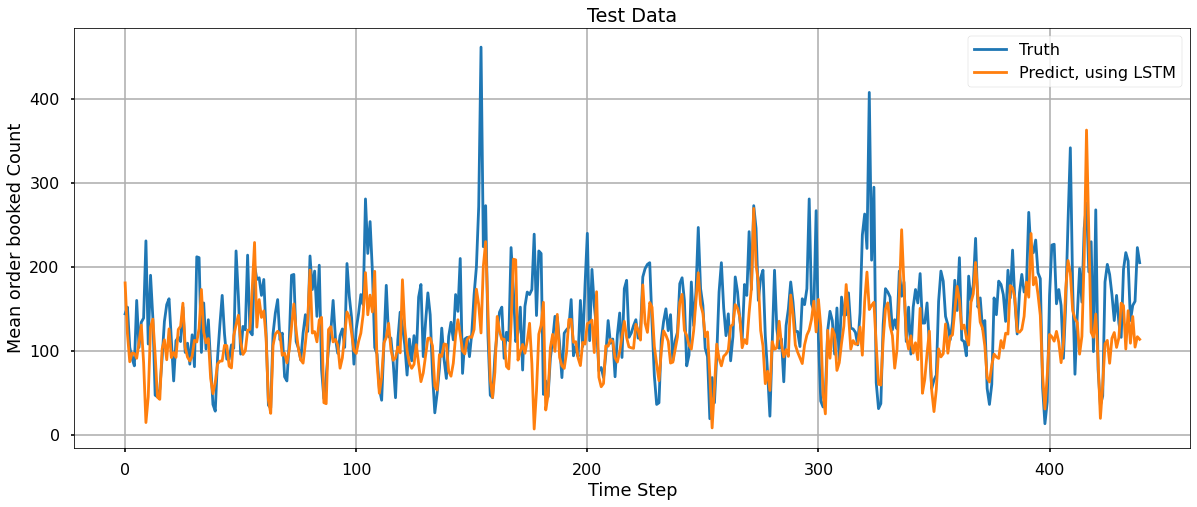

In [39]:
# make a simple function for this, comparing truth to predictions
plt.figure(figsize=(20,17))
plt.style.use('seaborn-poster')
plt.subplot(2,1,1)
#plt.plot(predictions[0][0:100])
plt.plot(inv_y, label='Truth')
plt.plot(inv_yhat, label='Predict, using LSTM')
plt.ylabel('Mean order booked Count')
plt.xlabel('Time Step')
plt.title('Test Data')
plt.legend()

In [38]:
# mean_squared_error(y_true, y_pred)
mean_squared_error(inv_yhat, inv_y)

2919.5169820199394